<a href="https://colab.research.google.com/github/yukthasree-pasala/fetch-data-analysis/blob/main/fetch_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Exercise - 1:
First: explore the data
Review the unstructured csv files and answer the following questions with code that supports your conclusions:

* Are there any data quality issues present?
* Are there any fields that are challenging to understand?
* We recommend using SQL or python and data visualization to examine the data.



In [1]:
# Import necessary libraries and mount the drive
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for countplot
import sqlite3
import numpy as np

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#define file paths
products_fp = '/content/drive/MyDrive/fetch-data-analysis/data/PRODUCTS_TAKEHOME.csv'
transactions_fp = '/content/drive/MyDrive/fetch-data-analysis/data/TRANSACTION_TAKEHOME.csv'
users_fp = '/content/drive/MyDrive/fetch-data-analysis/data/USER_TAKEHOME.csv'

#load csv files to df
products_df = pd.read_csv(products_fp, dtype={'BARCODE': str})
transactions_df = pd.read_csv(transactions_fp, dtype={'BARCODE': str})
users_df = pd.read_csv(users_fp)
pd.options.display.float_format = '{:.0f}'.format

In [3]:
# Connect to SQLite (in-memory)
conn = sqlite3.connect(':memory:')  # For temporary DB
cursor = conn.cursor()


#Data Quality Analysis

In [4]:
def display_dataframe_info(df, df_name):
  """Displays column names and statistics for a DataFrame in a table format."""
  print(f"### {df_name} ###")
  info_df = pd.DataFrame({
      'Column Name': df.columns,
      'Data Type': df.dtypes,
      'Non-Null Count': df.notna().sum(),
      'Unique Records': df.nunique(),
      'Duplicated Records': df.duplicated().sum(),
      'Missing Values': df.isna().sum()

  })

  print(info_df.to_markdown(index=False))
  print("\n")

display_dataframe_info(users_df, "users_df")
display_dataframe_info(transactions_df, "transactions_df")
display_dataframe_info(products_df, "products_df")


### users_df ###
| Column Name   | Data Type   |   Non-Null Count |   Unique Records |   Duplicated Records |   Missing Values |
|:--------------|:------------|-----------------:|-----------------:|---------------------:|-----------------:|
| ID            | object      |           100000 |           100000 |                    0 |                0 |
| CREATED_DATE  | object      |           100000 |            99942 |                    0 |                0 |
| BIRTH_DATE    | object      |            96325 |            54721 |                    0 |             3675 |
| STATE         | object      |            95188 |               52 |                    0 |             4812 |
| LANGUAGE      | object      |            69492 |                2 |                    0 |            30508 |
| GENDER        | object      |            94108 |               11 |                    0 |             5892 |


### transactions_df ###
| Column Name    | Data Type   |   Non-Null Count |   Unique 

## Data Quality Issues & Field Understanding Challenges

### 📋 **1. Users Dataset (users_df)**

**Data Quality Issues:**
- **Missing Values:**
  - BIRTH_DATE: 3,675 missing (3.68%)
  - STATE: 4,812 missing (4.81%)
  - LANGUAGE: 30,508 missing (30.51%) - Significant gap
  - GENDER: 5,892 missing (5.89%)
- **Duplicates:** None detected
- **Data Type Issues:** CREATED_DATE and BIRTH_DATE should be datetime, currently stored as object.

**Challenging Fields:**
- **GENDER (11 unique values):** Inconsistent labels (e.g., "M", "Male", "F", "Female", typos). Requires standardization.
- **LANGUAGE (2 unique values):** Ambiguity around what the values represent (user preference, locale, etc.).

---

### 🧾 **2. Transactions Dataset (transactions_df)**

**Data Quality Issues:**
- **Missing Values:**
  - BARCODE: 5,762 missing (11.52%) - Critical for linking with products
- **Duplicates:** 171 duplicate records (potential data entry issues)
- **Data Type Issues:**
  - FINAL_QUANTITY and FINAL_SALE are objects, should be numeric
  - PURCHASE_DATE and SCAN_DATE are objects, should be datetime

**Challenging Fields:**
- **FINAL_QUANTITY & FINAL_SALE:** Possible formatting issues (e.g., special characters). Requires cleaning before analysis.
- **BARCODE:** Missing values affect data integrity when joining with products. Need clarification if this is expected.

---

### 🛒 **3. Products Dataset (products_df)**

**Data Quality Issues:**
- **Missing Values:**
  - CATEGORY_4: 778,093 missing (91.99%) - Extremely sparse
  - MANUFACTURER: 226,474 missing (26.77%)
  - BRAND: 226,472 missing (26.77%)
  - BARCODE: 4,025 missing (0.48%)
- **Duplicates:** 215 duplicate records identified

**Challenging Fields:**
- **CATEGORY_1 to CATEGORY_4:** Hierarchical relationship unclear, impacting categorization analysis.
- **MANUFACTURER vs. BRAND:** Unclear if these fields are distinct or overlapping, affecting brand performance analysis.

---

### **Next steps for above issues:**
1. **Data Cleaning:** Remove duplicates, convert data types, standardize GENDER labels.
2. **Missing Data Handling:** Impute or investigate missing demographic and product data.




In [5]:
users = users_df.copy()

In [6]:
# ----------------------
# USERS DATA CLEANING
# ----------------------

# Standardize GENDER values
gender_map = {
    'M': 'Male', 'MALE': 'Male', 'male': 'Male',
    'F': 'Female', 'FEMALE': 'Female', 'female': 'Female',
    'U': 'Unknown', 'UNKNOWN': 'Unknown', 'UNKOWN': 'Unknown', '': np.nan,
    'PREFER NOT TO SAY': 'Prefer not to say', 'Prefer not to say': 'Prefer not to say',
    'prefer_not_to_say': 'Prefer not to say',
    'NOT_LISTED': 'Not specified', 'NOT_SPECIFIED': 'Not specified',
    "MY GENDER ISN'T LISTED": 'Not specified',
    'NON_BINARY': 'Non-binary', 'NON-BINARY': 'Non-binary', 'Non-Binary': 'Non-binary',
    'non_binary': 'Non-binary', 'Non-binary': 'Non-binary',
    'TRANSGENDER': 'Transgender', 'transgender': 'Transgender'
}

# Apply gender mapping efficiently using `.str.upper()` for case insensitivity
users['GENDER'] = users['GENDER'].str.upper().map(gender_map).fillna('Unknown')

# Fill missing values with 'Unknown' if any are left
users['GENDER'] = users['GENDER'].fillna('Unknown')

# Handle LANGUAGE missing values (impute with mode)
# users['LANGUAGE'] = users['LANGUAGE'].fillna(users['LANGUAGE'].mode()[0])

# Handle LANGUAGE missing values (impute with mode)
language_map = {
    'es-419' : 'Spanish - Latin America',
    'en': 'English'
}
# Apply mapping only to original values
users['LANGUAGE'] = users['LANGUAGE'].apply(lambda x: language_map[x] if x in language_map else x).fillna('Unknown')

# Fill nulls with Unkown for state
users['STATE'] = users['STATE'].fillna('Unkown')

# Convert BIRTH_DATE to datetime and handle missing values
users['BIRTH_DATE'] = pd.to_datetime(users['BIRTH_DATE'], errors='coerce')

In [7]:
# display users unique values
print(users['GENDER'].unique())
print(users['LANGUAGE'].unique())
print(users['STATE'].unique())



['Female' 'Unknown' 'Male' 'Non-binary' 'Transgender' 'Not specified'
 'Prefer not to say']
['Spanish - Latin America' 'English' 'Unknown']
['CA' 'PA' 'FL' 'NC' 'NY' 'IN' 'Unkown' 'OH' 'TX' 'NM' 'PR' 'CO' 'AZ' 'RI'
 'MO' 'NJ' 'MA' 'TN' 'LA' 'NH' 'WI' 'IA' 'GA' 'VA' 'DC' 'KY' 'SC' 'MN'
 'WV' 'DE' 'MI' 'IL' 'MS' 'WA' 'KS' 'CT' 'OR' 'UT' 'MD' 'OK' 'NE' 'NV'
 'AL' 'AK' 'AR' 'HI' 'ME' 'ND' 'ID' 'WY' 'MT' 'SD' 'VT']


###Transactions Cleaning

In [8]:
transactions = transactions_df.copy()

print(transactions.head(10).to_markdown(index=False))
print("\n")
display_dataframe_info(transactions, "transactions_df")

| RECEIPT_ID                           | PURCHASE_DATE   | SCAN_DATE                 | STORE_NAME   | USER_ID                  |       BARCODE | FINAL_QUANTITY   | FINAL_SALE   |
|:-------------------------------------|:----------------|:--------------------------|:-------------|:-------------------------|--------------:|:-----------------|:-------------|
| 0000d256-4041-4a3e-adc4-5623fb6e0c99 | 2024-08-21      | 2024-08-21 14:19:06.539 Z | WALMART      | 63b73a7f3d310dceeabd4758 |   1.53e+10    | 1.00             |              |
| 0001455d-7a92-4a7b-a1d2-c747af1c8fd3 | 2024-07-20      | 2024-07-20 09:50:24.206 Z | ALDI         | 62c08877baa38d1a1f6c211a | nan           | zero             | 1.49         |
| 00017e0a-7851-42fb-bfab-0baa96e23586 | 2024-08-18      | 2024-08-19 15:38:56.813 Z | WALMART      | 60842f207ac8b7729e472020 |   7.87422e+10 | 1.00             |              |
| 000239aa-3478-453d-801e-66a82e39c8af | 2024-06-18      | 2024-06-19 11:03:37.468 Z | FOOD LION    | 63f

In [9]:
# Convert FINAL_QUANTITY to numeric, handling non-numeric values like "zero"
transactions['FINAL_QUANTITY'] = transactions['FINAL_QUANTITY'].replace({'zero': 0}).astype(float)

# Convert FINAL_SALE to numeric, filling missing values with 0.00
transactions['FINAL_SALE'] = pd.to_numeric(transactions['FINAL_SALE'], errors='coerce').fillna(0.00)

# Remove duplicates based on RECEIPT_ID, USER_ID, and BARCODE
transactions_cleaned = transactions.drop_duplicates(subset=['RECEIPT_ID', 'USER_ID', 'BARCODE'], keep='first')

print('transactions after deduplication:', len(transactions_cleaned))

transactions_cleaned = transactions_cleaned.copy()

# Now apply the flag safely
transactions_cleaned['FLAG_ZERO_QUANTITY'] = transactions_cleaned['FINAL_QUANTITY'] == 0

print(transactions_cleaned.head(10).to_markdown(index=False))


transactions after deduplication: 24795
| RECEIPT_ID                           | PURCHASE_DATE   | SCAN_DATE                 | STORE_NAME   | USER_ID                  |       BARCODE |   FINAL_QUANTITY |   FINAL_SALE | FLAG_ZERO_QUANTITY   |
|:-------------------------------------|:----------------|:--------------------------|:-------------|:-------------------------|--------------:|-----------------:|-------------:|:---------------------|
| 0000d256-4041-4a3e-adc4-5623fb6e0c99 | 2024-08-21      | 2024-08-21 14:19:06.539 Z | WALMART      | 63b73a7f3d310dceeabd4758 |   1.53e+10    |                1 |         0    | False                |
| 0001455d-7a92-4a7b-a1d2-c747af1c8fd3 | 2024-07-20      | 2024-07-20 09:50:24.206 Z | ALDI         | 62c08877baa38d1a1f6c211a | nan           |                0 |         1.49 | True                 |
| 00017e0a-7851-42fb-bfab-0baa96e23586 | 2024-08-18      | 2024-08-19 15:38:56.813 Z | WALMART      | 60842f207ac8b7729e472020 |   7.87422e+10 |        

In [10]:
display_dataframe_info(transactions_cleaned, "transactions_df")

### transactions_df ###
| Column Name        | Data Type   |   Non-Null Count |   Unique Records |   Duplicated Records |   Missing Values |
|:-------------------|:------------|-----------------:|-----------------:|---------------------:|-----------------:|
| RECEIPT_ID         | object      |            24795 |            24440 |                    0 |                0 |
| PURCHASE_DATE      | object      |            24795 |               89 |                    0 |                0 |
| SCAN_DATE          | object      |            24795 |            24440 |                    0 |                0 |
| STORE_NAME         | object      |            24795 |              954 |                    0 |                0 |
| USER_ID            | object      |            24795 |            17694 |                    0 |                0 |
| BARCODE            | object      |            21979 |            11028 |                    0 |             2816 |
| FINAL_QUANTITY     | float64     |    

In [11]:
transactions_cleaned['BARCODE'] = pd.to_numeric(transactions_cleaned['BARCODE'], errors='coerce')

# Now check for missing values
print(transactions_cleaned['BARCODE'].isnull().sum(), "transactions have missing barcodes.")

# Total number of transactions
total_transactions = len(transactions_cleaned)

# Count of missing barcode transactions
missing_barcodes = transactions_cleaned['BARCODE'].isnull().sum()

# Calculate percentage
missing_percentage = (missing_barcodes / total_transactions) * 100

# Print result
print(f"Missing Barcode Percentage: {missing_percentage:.2f}%")


2816 transactions have missing barcodes.
Missing Barcode Percentage: 11.36%


In [27]:
total_transactions_by_store = transactions_cleaned['STORE_NAME'].value_counts()

# Missing barcode transactions per store
missing_barcode_by_store = transactions_cleaned[transactions_cleaned['BARCODE'].isnull()]['STORE_NAME'].value_counts()

# Calculate the percentage of missing barcodes per store
missing_percentage_by_store = (missing_barcode_by_store / total_transactions_by_store) * 100

# Combine results into a DataFrame
missing_barcode_summary = pd.DataFrame({
    'Total_Transactions': total_transactions_by_store,
    'Missing_Barcodes': missing_barcode_by_store,
    'Missing_Percentage': missing_percentage_by_store
}).fillna(0)  # Fill NaN for stores with 0 missing barcodes

# Sort by highest missing percentage
missing_barcode_summary = missing_barcode_summary.sort_values(by='Missing_Percentage', ascending=False)

# Print the results in markdown format for better readability
print(missing_barcode_summary.head(50).to_markdown())



| STORE_NAME                            |   Total_Transactions |   Missing_Barcodes |   Missing_Percentage |
|:--------------------------------------|---------------------:|-------------------:|---------------------:|
| THE TRUE LOW PRICE LEADER             |                    1 |                  1 |                  100 |
| CHAR&LEMON                            |                    1 |                  1 |                  100 |
| KUHN'S MARKET                         |                    1 |                  1 |                  100 |
| THE HALF WALL BEER HOUSE              |                    1 |                  1 |                  100 |
| CARNICERIA LOS DOS RIOS               |                    1 |                  1 |                  100 |
| CASH WISE                             |                    1 |                  1 |                  100 |
| KINNEY DRUGS                          |                    1 |                  1 |                  100 |
| TEAL'S MARKET    

###PRODUCTS CLEANING

In [13]:
products = products_df.copy()
print(products.head(10).to_markdown(index=False))
print("\n")

| CATEGORY_1        | CATEGORY_2                 | CATEGORY_3                       |   CATEGORY_4 | MANUFACTURER                                           | BRAND           |       BARCODE |
|:------------------|:---------------------------|:---------------------------------|-------------:|:-------------------------------------------------------|:----------------|--------------:|
| Health & Wellness | Sexual Health              | Conductivity Gels & Lotions      |          nan | nan                                                    | nan             |   7.96494e+11 |
| Snacks            | Puffed Snacks              | Cheese Curls & Puffs             |          nan | nan                                                    | nan             |   2.3278e+10  |
| Health & Wellness | Hair Care                  | Hair Care Accessories            |          nan | PLACEHOLDER MANUFACTURER                               | ELECSOP         |   4.61818e+11 |
| Health & Wellness | Oral Care         

In [14]:
# ----------------------
#PRODUCTS CLEANING
# ----------------------

# Drop CATEGORY_4 if sparsity is too high (>90% missing)
if products['CATEGORY_4'].isnull().mean() > 0.9:
    products.drop(columns=['CATEGORY_4'], inplace=True)

# Handle MANUFACTURER & BRAND missing values (fill with 'Unknown' if missing)
products['MANUFACTURER'].fillna('Unknown', inplace=True)
products['BRAND'].fillna('Unknown', inplace=True)

# Investigate missing BARCODEs
products['MISSING_BARCODE_FLAG'] = products['BARCODE'].isnull()

# Remove duplicate products
products = products.drop_duplicates()


<ipython-input-14-08a28c91e936>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  products['MANUFACTURER'].fillna('Unknown', inplace=True)
<ipython-input-14-08a28c91e936>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [15]:
display_dataframe_info(users, "users")
display_dataframe_info(transactions_cleaned, "transactions")
display_dataframe_info(products, "products")

### users ###
| Column Name   | Data Type           |   Non-Null Count |   Unique Records |   Duplicated Records |   Missing Values |
|:--------------|:--------------------|-----------------:|-----------------:|---------------------:|-----------------:|
| ID            | object              |           100000 |           100000 |                    0 |                0 |
| CREATED_DATE  | object              |           100000 |            99942 |                    0 |                0 |
| BIRTH_DATE    | datetime64[ns, UTC] |            96325 |            54721 |                    0 |             3675 |
| STATE         | object              |           100000 |               53 |                    0 |                0 |
| LANGUAGE      | object              |           100000 |                3 |                    0 |                0 |
| GENDER        | object              |           100000 |                7 |                    0 |                0 |


### transactions ###
| C

In [16]:
# Load DataFrames into SQL tables
users.to_sql('users', conn, index=False, if_exists='replace')
transactions_cleaned.to_sql('transactions', conn, index=False, if_exists='replace')
products.to_sql('products', conn, index=False, if_exists='replace')

845286

Second: provide SQL queries
Answer three of the following questions with at least one question coming from the closed-ended and one from the open-ended question set. Each question should be answered using one query.
* Closed-ended questions:
1. What are the top 5 brands by receipts scanned among users 21 and over?
2. What are the top 5 brands by sales among users that have had their account for at least six months?
3. What is the percentage of sales in the Health & Wellness category by generation?
* Open-ended questions: for these, make assumptions and clearly state them when answering the question.
4. Who are Fetch’s power users?
5. Which is the leading brand in the Dips & Salsa category?
6. At what percent has Fetch grown year over year?

###1. What are the top 5 brands by receipts scanned among users 21 and over?

In [17]:
query = """
SELECT p.BRAND, COUNT(t.RECEIPT_ID) AS receipts_scanned
FROM transactions t
JOIN users u ON t.USER_ID = u.ID
JOIN products p ON t.BARCODE = p.BARCODE
WHERE (strftime('%Y', 'now') - strftime('%Y', u.BIRTH_DATE)) >= 21
AND p.BRAND != 'Unknown'  -- Exclude unknown brands
GROUP BY p.BRAND
ORDER BY receipts_scanned DESC
LIMIT 5;
"""
# Execute query and fetch results
top_brands = pd.read_sql_query(query, conn)
print(top_brands)

             BRAND  receipts_scanned
0      NERDS CANDY                 3
1             DOVE                 3
2          TRIDENT                 2
3  SOUR PATCH KIDS                 2
4           MEIJER                 2


###2. What are the top 5 brands by sales among users that have had their account for at least six months?

In [18]:
query = """
SELECT p.BRAND, SUM(t.FINAL_SALE) AS total_sales
FROM transactions t
JOIN users u ON t.USER_ID = u.ID
JOIN products p ON t.BARCODE = p.BARCODE
WHERE julianday('now') - julianday(u.CREATED_DATE) >= 180
GROUP BY p.BRAND
ORDER BY total_sales DESC
LIMIT 5;
"""

# Execute and fetch results
top_sales_brands = pd.read_sql_query(query, conn)
print(top_sales_brands)


         BRAND  total_sales
0      TRIDENT           23
1  COORS LIGHT           17
2         DOVE           12
3       QUAKER            8
4          AXE            8


###3. What is the percentage of sales in the Health & Wellness category by generation?

In [19]:
# SQL Query to Calculate Health & Wellness Sales Percentage
query = """
WITH category_sales AS (
    SELECT
        SUM(t.FINAL_SALE) AS health_wellness_sales
    FROM transactions t
    JOIN products p ON t.BARCODE = p.BARCODE
    WHERE p.CATEGORY_1 = 'Health & Wellness'
),
total_sales AS (
    SELECT
        SUM(FINAL_SALE) AS overall_sales
    FROM transactions
)
SELECT
    cs.health_wellness_sales,
    ts.overall_sales,
    ROUND((cs.health_wellness_sales * 100.0) / ts.overall_sales, 2) AS health_wellness_percentage
FROM category_sales cs, total_sales ts;
"""

# Execute query and fetch results into a DataFrame
health_wellness_sales_percentage = pd.read_sql_query(query, conn)

# Display the results
print(health_wellness_sales_percentage)

   health_wellness_sales  overall_sales  health_wellness_percentage
0                  13871          57083                          24


4. Who are Fetch’s power users?

* Rewards are earned per receipt → Users scanning more receipts get higher priority.
* Frequent & bulk shoppers show engagement → Buying more items means active participation.
* High spenders are valuable for brand deals → Fetch can target brand partnerships for top spenders.

In [20]:
query = """
WITH user_receipts AS (
    SELECT USER_ID, COUNT(RECEIPT_ID) AS total_receipts
    FROM transactions
    GROUP BY USER_ID
),
user_items AS (
    SELECT USER_ID, SUM(FINAL_QUANTITY) AS total_items_purchased
    FROM transactions
    GROUP BY USER_ID
),
user_spending AS (
    SELECT USER_ID, SUM(FINAL_SALE) AS total_spent
    FROM transactions
    GROUP BY USER_ID
)
SELECT u.ID AS user_id, u.CREATED_DATE,
       ur.total_receipts, ui.total_items_purchased, us.total_spent,
       ROUND(ui.total_items_purchased * 1.0 / ur.total_receipts, 2) AS avg_items_per_receipt
FROM users u
JOIN user_receipts ur ON u.ID = ur.USER_ID
JOIN user_items ui ON u.ID = ui.USER_ID
JOIN user_spending us ON u.ID = us.USER_ID
ORDER BY ur.total_receipts DESC, ui.total_items_purchased DESC, us.total_spent DESC
LIMIT 10;
"""

power_users_fetch = pd.read_sql_query(query, conn)
print(power_users_fetch)


                    user_id               CREATED_DATE  total_receipts  \
0  61a58ac49c135b462ccddd1c  2021-11-30 02:21:56.000 Z               3   
1  5f64fff6dc25c93de0383513  2020-09-18 18:44:07.000 Z               3   
2  646bdaa67a342372c857b958  2023-05-22 21:12:06.000 Z               3   
3  62c09104baa38d1a1f6c260e  2022-07-02 18:40:04.000 Z               3   
4  610a8541ca1fab5b417b5d33  2021-08-04 12:17:05.000 Z               3   
5  5c366bf06d9819129dfa1118  2019-01-09 21:47:28.000 Z               3   
6  62ffec490d9dbaff18c0a999  2022-08-19 20:02:17.000 Z               3   
7  6528a0a388a3a884364d94dc  2023-10-13 01:42:59.000 Z               3   
8  5ca54049adfcb4140b54e1bf  2019-04-03 23:22:49.000 Z               2   
9  5f222804d52f48146ba7112e  2020-07-30 01:53:09.000 Z               2   

   total_items_purchased  total_spent  avg_items_per_receipt  
0                      2            5                      1  
1                      2            3                      

5. Which is the leading brand in the Dips & Salsa category?
* All variations should be included if they contain "Dips" or "Salsa".
* The leading brand is determined by total sales (SUM(FINAL_SALE)).
* If there is a tie, we use transaction count (COUNT(RECEIPT_ID)) as a tiebreaker.

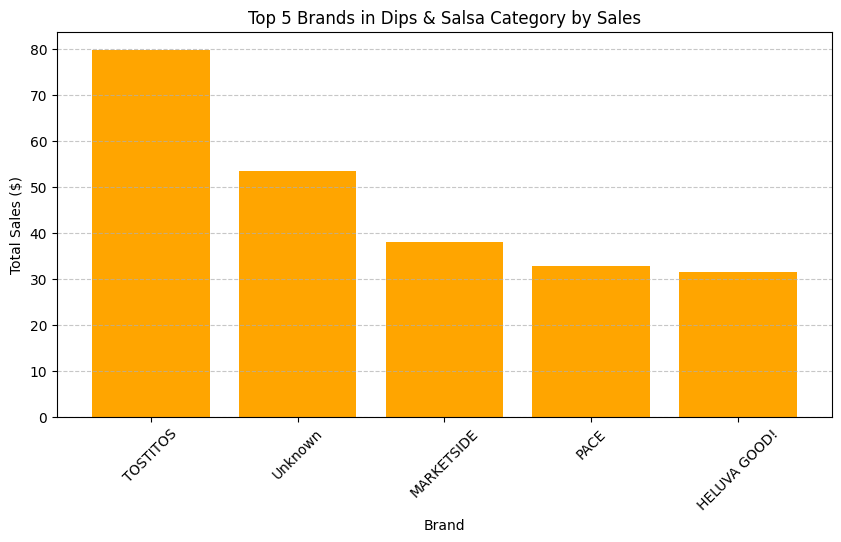

In [21]:
query = """
SELECT p.BRAND, SUM(t.FINAL_SALE) AS total_sales, COUNT(t.RECEIPT_ID) AS transaction_count
FROM transactions t
JOIN products p ON t.BARCODE = p.BARCODE
WHERE
    p.CATEGORY_1 LIKE '%Dips & Salsa%'
    OR p.CATEGORY_2 LIKE '%Dips & Salsa%'
    OR p.CATEGORY_3 LIKE '%Dips & Salsa%'
GROUP BY p.BRAND
ORDER BY total_sales DESC, transaction_count DESC
LIMIT 5;
"""
top_brands_dips_salsa  = pd.read_sql_query(query, conn)
# Visualization: Bar Chart of Top 5 Brands by Sales
plt.figure(figsize=(10, 5))
plt.bar(top_brands_dips_salsa['BRAND'], top_brands_dips_salsa['total_sales'], color='orange')
plt.xlabel('Brand')
plt.ylabel('Total Sales ($)')
plt.title('Top 5 Brands in Dips & Salsa Category by Sales')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

6. At what percent has Fetch grown year over year?

In [24]:
# SQL Query to Calculate Year-over-Year Growth in Transactions for Fetch
query = """
WITH yearly_transactions AS (
    SELECT strftime('%Y', PURCHASE_DATE) AS year, COUNT(RECEIPT_ID) AS total_transactions
    FROM transactions
    WHERE FINAL_SALE > 0  -- Consider only completed transactions
    GROUP BY year
)
SELECT
    year,
    total_transactions,
    LAG(total_transactions) OVER (ORDER BY year) AS previous_year_transactions,
    ROUND(
        (total_transactions - LAG(total_transactions) OVER (ORDER BY year)) * 100.0 /
        LAG(total_transactions) OVER (ORDER BY year), 2
    ) AS growth_percentage
FROM yearly_transactions;
"""

# Execute query and fetch results into DataFrame
fetch_growth_yoy = pd.read_sql_query(query, conn)

# Print results
print(fetch_growth_yoy)


   year  total_transactions previous_year_transactions growth_percentage
0  2024               12242                       None              None


In [25]:


# Convert year column to string for plotting
fetch_growth_yoy['year'] = fetch_growth_yoy['year'].astype(str)

# Check if there's enough data to plot
if fetch_growth_yoy.shape[0] > 1:
    # Plot Year-over-Year Growth Percentage
    plt.figure(figsize=(8, 5))
    plt.plot(fetch_growth_yoy['year'], fetch_growth_yoy['growth_percentage'], marker='o', linestyle='-', color='blue')
    plt.xlabel('Year')
    plt.ylabel('Growth Percentage (%)')
    plt.title('Fetch Year-over-Year Growth')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show data points
    for i, txt in enumerate(fetch_growth_yoy['growth_percentage']):
        plt.annotate(f"{txt}%", (fetch_growth_yoy['year'][i], fetch_growth_yoy['growth_percentage'][i]),
                     textcoords="offset points", xytext=(0,5), ha='center')

    plt.show()
else:
    print("Not enough data to calculate year-over-year growth.")


Not enough data to calculate year-over-year growth.
